# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 2 people, the notebook should be named:
12301230_3434343_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Konstantinos Papakostas"
NAME2 = "Apostolos Panagiotopoulos"
EMAIL = "konstantinos.papakostas@student.uva.nl"
EMAIL2 = "apostolos.panagiotopoulos@student.uva.nl"

# Lab 2: Classification

### Machine Learning 1, September/October 2021

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Do not delete/add cells. Also do not change the number of arguments in the given code.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct.
* Do not delete add new cells to your solution. Also do not change the number of arguments in the given methods.
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

**IMPORTANT: Note that for this coding exercise we are using flipped notation (denominator layout) for the gradient and the derivations.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

Reference materials for this assignment:
- Bishop's book Section 4.3 (4.3.1-4.3.4) for the logistic regression and Section 5.1-5.3 for the Neural Networks
- Erik's Lecture 6.4 for logistic regression and 8.1-8.5 for Neural Networks.

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

You have a friend with one big problem which needs your help: Your friend wants to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data

try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

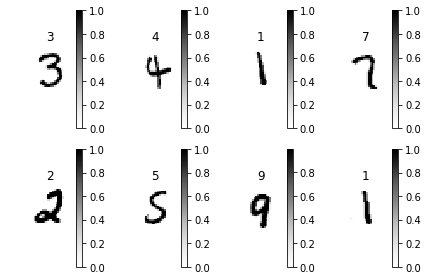

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
$$
\begin{aligned}
    \delta^q_j
    & = 1 - \frac{\partial \log Z}{\partial Z} \frac{\partial Z}{\partial \log q_j} \\
    & = 1 - \dfrac{1}{Z} \dfrac{\partial Z}{\partial \log q_j} \\
    & = 1 - \dfrac{1}{\sum_i \exp(\log q_i)} \dfrac{\partial \sum_i \exp(\log q_i)}{\partial \log q_j} \\
    & = 1 - \dfrac{1}{\sum_i \exp(\log q_i)} \dfrac{\partial \exp(\log q_j)}{\partial \log q_j} \\
    & = 1 - \dfrac{1}{\sum_i \exp(\log q_i)} \exp(\log q_j) \\
    & = 1 - \dfrac{\exp(\log q_j)}{\sum_i \exp(\log q_i)}
\end{aligned}
$$

For $j \neq t^{(n)}$:
$$
\begin{aligned}
    \delta^q_j
    & = 0 - \frac{\partial \log Z}{\partial Z} \frac{\partial Z}{\partial \log q_j} \\
    & = - \dfrac{1}{Z} \dfrac{\partial Z}{\partial \log q_j} \\
    & = - \dfrac{1}{\sum_i \exp(\log q_i)} \dfrac{\partial \sum_i \exp(\log q_i)}{\partial \log q_j} \\
    & = - \dfrac{1}{\sum_i \exp(\log q_i)} \dfrac{\partial \exp(\log q_j)}{\partial \log q_j} \\
    & = - \dfrac{1}{\sum_i \exp(\log q_i)} \exp(\log q_j) \\
    & = - \dfrac{\exp(\log q_j)}{\sum_i \exp(\log q_i)}
\end{aligned}
$$

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$$
\begin{aligned}
    \frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}
    & = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \frac{\partial \log q_j}{\partial W_{ij}} \\
    & = \mathbf{\delta}_j^q ~ \frac{\partial \left( \mathbf{w}^T_j \mathbf{x} + b_j \right)}{\partial W_{ij}} \\
    & = \mathbf{\delta}_j^q ~ \frac{\partial \left( \sum_{i}W_{ij}x_i + b_j \right)}{\partial W_{ij}} \\
    & = \mathbf{\delta}_j^q ~ x_i
\end{aligned}
$$

We can vectorize the above equation as such:

$$
    \nabla_{\mathbf{W}} \mathcal{L}^{(n)} = \mathbf{x} \left( \mathbf{\delta}^q \right)^T
$$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
plt.rcParams["figure.figsize"] = [9,5]

# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    logq = x @ w + b.T

    a = np.max(logq)
    logZ = a + np.log(np.sum(np.exp(logq - a)))

    logp = logq - logZ

    ndims = b.shape[0]
    delta_q = np.eye(ndims)[t] - np.exp(logq) / np.exp(logZ)

    # derivative of loss w.r.t. model parameters W and b
    dL_db = delta_q
    dL_dw = x.T @ delta_q
    
    # here the statement contains logp[:,t] where logp is meant as a matrix of shape 1x10
    return logp[:, t].squeeze(), dL_dw, dL_db.squeeze()

In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.3612946893e-07
Finite difference error grad_b: 5.23511748609e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    N = x_train.shape[0]
    lr = 1e-4
    
    logp_train = np.zeros(N)
    for i, idx in enumerate(np.random.permutation(N)):
        logpt, grad_W, grad_b = logreg_gradient(x_train[idx:idx+1, :], t_train[idx:idx+1], W, b)
        logp_train[i] = logpt

        # gradient ascent
        W += lr * grad_W
        b += lr * grad_b
        
    
    return logp_train, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

Train Dataset conditional log-likelihood: -0.3951706969886347
Train Dataset accuracy: 0.89424
Validation Dataset conditional log-likelihood: -0.40857988865780814
Validation Dataset accuracy: 0.8906


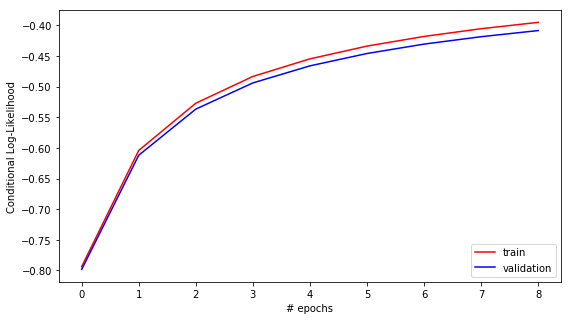

In [14]:
import matplotlib.pyplot as plt

def log_likelihood(x, t, w, b):
    logq = x @ w + b.T
    
    a = np.max(logq, axis=1)
    logZ = a + np.log(np.sum(np.exp(logq - a.reshape(-1, 1)), axis=1))
    
    logp = logq[np.arange(t.shape[0]), t] - logZ
    
    return logp

def logreg_predict_class(x, w, b):
    logq = x @ w + b.T
    
    return logq.argmax(axis=1)

def logreg_acc(x, t, w, b):
    return (logreg_predict_class(x, w, b) == t).sum() / len(t)

def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    train_lll = []
    valid_lll = []
    
    while True:
        # train
        _, w, b = sgd_iter(x_train, t_train, w, b)
        train_lll.append(log_likelihood(x_train, t_train, w, b).mean())

        # validation
        valid_lll.append(log_likelihood(x_valid, t_valid, w, b).mean())
        
        # stop when the relative change in validation log-likelihood is less than 2.5%
        if len(valid_lll) > 1:
            if np.abs((valid_lll[-1] - valid_lll[-2]) / valid_lll[-2]) < 0.025:
                break
                
    print(f'Train Dataset conditional log-likelihood: {train_lll[-1]}')
    print(f'Train Dataset accuracy: {logreg_acc(x_train, t_train, w, b)}')
    print(f'Validation Dataset conditional log-likelihood: {valid_lll[-1]}')
    print(f'Validation Dataset accuracy: {logreg_acc(x_valid, t_valid, w, b)}')
        
    plt.plot(train_lll, 'r', label='train')
    plt.plot(valid_lll, 'b', label='validation')
    plt.xlabel('# epochs')
    plt.ylabel('Conditional Log-Likelihood')
    plt.legend(loc='lower right')
    
    return w, b
    
np.random.seed(123)
w = np.random.normal(size=(28*28,10), scale=0.001)
b = np.zeros((10,))
w, b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


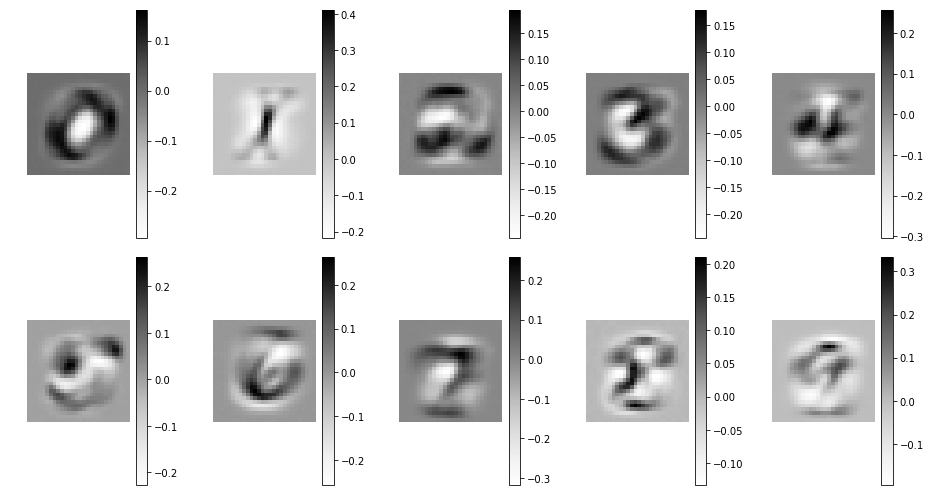

In [16]:
plt.figure(figsize(13, 7))
plot_digits(w.T, 5)

**Describe in less than 100 words why these weights minimize the loss**

We observe that each weight vector $\mathbf{w}_j$ looks like an outline of the corresponding digit $j$. When evaluating the activation $\sigma (\mathbf{w}_j^T \mathbf{x}^{(n)})$, each black pixel in $\mathbf{x}^{(n)}$ that is on the "black region" of $\mathbf{w}_j$ contributes positively and each black pixel that is on the "white region" contributes negatively. Hence, each input $\mathbf{x}^{(n)}$ gives a high activation to the weight vector that looks the most similar to it (which will be the weight vector of its true class) and low activations on the others. This results in $ \log p(t = t^{(n)} \;|\; \bx, \bb, \bW) \rightarrow 0$, and thus the minimization of the loss.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


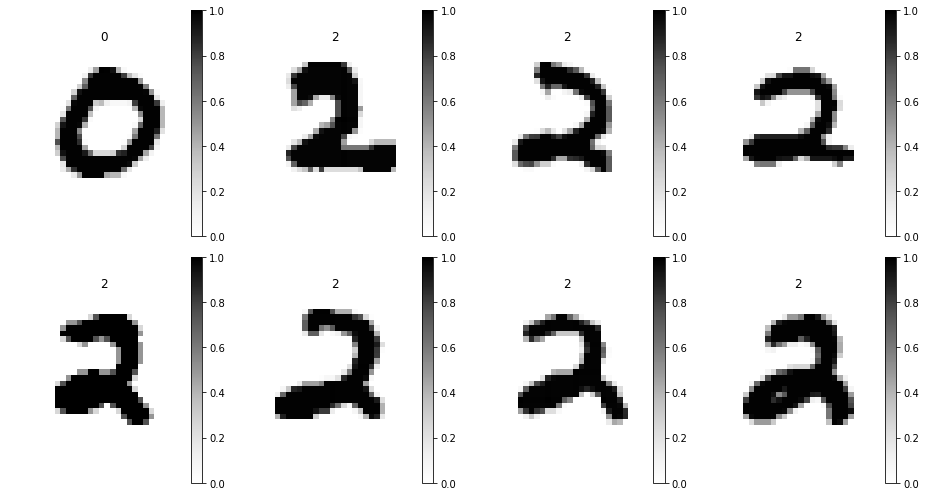

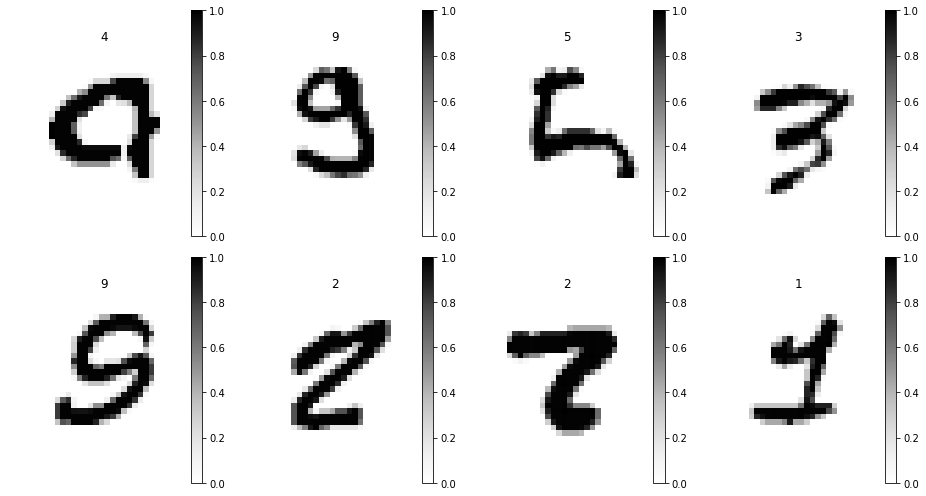

In [17]:
logp_valid = log_likelihood(x_valid, t_valid, w, b)
best_ind = np.argpartition(logp_valid, -8)[-8:]
worst_ind = np.argpartition(logp_valid, 8)[:8]
plot_digits(x_valid[best_ind], num_cols=4, targets=t_valid[best_ind])
plot_digits(x_valid[worst_ind], num_cols=4, targets=t_valid[worst_ind])

**Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.**

A digit is hard to classify if our model assigns it to more than one classes with almost equal probabilities, or equivalently if it assigns a low probability to its true class.

In the first plot we see instances of digits that are easy to classify. These digits exhibit minimal skewing or displacement, which makes it easy for our model to assign them to a unique class.

In the second plot we see instances of digits that are hard to classify. These digits are somehow distorted and have visual cues hinting to more than one classes. For example, the 4 in the second plot looks more like a 0, whereas the 2 looks equiprobably as a 2 and as 7.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

In the previous section, we had defined $\log q_j = \mathbf{w}_j^T \mathbf{x} + b_j$, which corresponds to the log of the unnormalized probabilty of a datapoint belonging to class $j$. Based on that, we calculated that $\nabla_\mathbf{b} \mathcal{L}^{(n)} = \mathbf{\delta}^q$ and $\nabla_{\mathbf{W}} \mathcal{L}^{(n)} = \mathbf{x} \left( \mathbf{\delta}^q \right)^T$.

In this case, we have $\log q_j = \mathbf{w}_j^T \mathbf{h} + b_j$, which differs from logistic regression in that the input is the activation of the hidden layer $\mathbf{h}$ instead of the features $\mathbf{x}$. Therefore, the gradient w.r.t. the biases $\mathbf{b}$ and weights $\mathbf{W}$ should be the same as above but considering $\mathbf{h}$ as the model's input (instead of $\mathbf{x}$):

$$
\begin{aligned}
    \nabla_{\mathbf{b}} \mathcal{L}^{(n)} &= \delta^{q} \\
    \nabla_{\mathbf{W}} \mathcal{L}^{(n)} &= \mathbf{h} \left( \mathbf{\delta}^q \right)^T = \mathbf{h} \left[ \nabla_{\mathbf{b}} \mathcal{L}^{(n)} \right]^T
\end{aligned}
$$
***
The error $\delta^h$ can be calculated as follows:

$$
\begin{aligned}
    \delta^h_j
    = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}
    = \sum_{k=1}^{10} \underbrace{\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k}}_{\delta^q_k} \frac{\partial \log q_k}{\partial h_j}
    = \sum_{k=1}^{10} \delta^q_k ~ \frac{\partial (\mathbf{w}_k^T \mathbf{h} + b_k)}{\partial h_j}
    = \sum_{k=1}^{10} \delta^q_k ~ \frac{\partial (\sum_{l=1}^{L} w_{kl} h_l + b_k)}{\partial h_j}
    = \sum_{k=1}^{10} \delta^q_k w_{kj}
\end{aligned}
$$

which can get vectorized as:
$$
\begin{aligned}
    \delta^h = W \delta^q
\end{aligned}
$$
***
The gradient of the parameters for the input layer $\mathbf{V}$ and $\mathbf{a}$ can be calculated as follows:

$$
\begin{aligned}
    \frac{\partial \mathcal{L}^{(n)}}{\partial V_{ij}}
    = \underbrace{\frac{\partial \mathcal{L}^{(n)}}{\partial h_j}}_{\delta_j^h} \frac{\partial h_j}{\partial V_{ij}}
    = \delta_j^h \frac{\partial \left( \sigma(\mathbf{v}_j^T \mathbf{x} + a_j) \right)}{\partial V_{ij}}
    \overset{[*]}{=} \delta_j^h h_j (1 - h_j) \frac{\partial (\mathbf{v}_j^T \mathbf{x} + a_j))}{\partial V_{ij}}
    = \delta_j^h h_j (1 - h_j) \frac{\partial \left( \sum_{i=1}^{784} V_{ij} x_i + a_j \right)}{\partial V_{ij}}
    = \delta_j^h h_j (1 - h_j) x_i
\end{aligned}
$$

$$
\begin{aligned}
    \frac{\partial \mathcal{L}^{(n)}}{\partial a_j}
    = \underbrace{\frac{\partial \mathcal{L}^{(n)}}{\partial h_j}}_{\delta_j^h} \frac{\partial h_j}{\partial a_j}
    = \delta_j^h \frac{\partial \left( \sigma(\mathbf{v}_j^T \mathbf{x} + a_j) \right)}{\partial a_j}
    \overset{[*]}{=} \delta_j^h h_j (1 - h_j) \frac{\partial (\mathbf{v}_j^T \mathbf{x} + a_j)}{\partial a_j}
    = \delta_j^h h_j (1 - h_j)
\end{aligned}
$$

Using the hadamard product, the previous gradients can vectorized as:
$$
\begin{aligned}
    \nabla_{\mathbf{a}} \mathcal{L}^{(n)} &= \delta^{h} \circ \mathbf{h} \circ (\mathbf{1} - \mathbf{h}) \\
    \nabla_{\mathbf{V}} \mathcal{L}^{(n)} &= \mathbf{x} \left[ \delta^{h} \circ \mathbf{h} \circ (\mathbf{1} - \mathbf{h}) \right]^T = \mathbf{x} ~ \left[ \nabla_{\mathbf{a}} \mathcal{L}^{(n)} \right]^T
\end{aligned}
$$
***
$[*]$ Assuming $\mathbf{f}(\mathbf{x}) = \mathbf{v}_j^T \mathbf{x} + a_j$, we have:
$$
\nabla_\mathbf{x} \mathbf{h}(\mathbf{x}) = \nabla_\mathbf{x} \sigma(\mathbf{f}(\mathbf{x}))
= \underbrace{\sigma(\mathbf{f}(\mathbf{x}))}_{\mathbf{h}(\mathbf{x})} (1 - \underbrace{\sigma(\mathbf{f}(\mathbf{x}))}_{\mathbf{h}(\mathbf{x})}) \nabla_\mathbf{x} \mathbf{f}(\mathbf{x})
$$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

In the previous step, we maximized the data likelihood to get an ML estimate, which is defined as:

$$
\begin{aligned}
    \mathcal{L} = \sum_{n=1}^N \mathcal{L^{(n)}} = \sum_{n=1}^N \log p(t = t^{(n)} | x^{(n)}, a, V, b, W)
    \overset{\text{i.i.d.}}{\Leftrightarrow}
    \mathcal{L} = \log p(T | X, a, V, b, W)
\end{aligned}
$$

Now, let's assume that the weights $\mathbf{w_j}$ are independent and follow the same Gaussian distribution: $\mathbf{w_j} \sim \mathcal{N}(\mathbf{0}, \sigma_W^{-1} \mathbf{I})$.

Similarly, let's assume: $\mathbf{a} \sim \mathcal{N}(\mathbf{0}, \sigma_a^{-1} \mathbf{I})$, $\mathbf{b} \sim \mathcal{N}(\mathbf{0}, \sigma_b^{-1} \mathbf{I})$ and $\mathbf{v_j} \sim \mathcal{N}(\mathbf{0}, \sigma_V^{-1} \mathbf{I})$.

We can then formulate our prior belief about the parameters as:

$$
\begin{aligned}
    p(\mathbf{a}, \mathbf{V}, \mathbf{b}, \mathbf{W} | \sigma_a, \sigma_V, \sigma_b, \sigma_W) 
    &= p(\mathbf{a} | \sigma_a) ~ p(\mathbf{V} | \sigma_V) ~ p(\mathbf{b} | \sigma_b) ~ p(\mathbf{W} | \sigma_W) \\
    &= \mathcal{N}(\mathbf{a} | \mathbf{0}, \sigma_a^{-1} \mathbf{I}) ~ \prod_{l=1}^{L} \mathcal{N}(\mathbf{v}_l | \mathbf{0}, \sigma_V^{-1} \mathbf{I}) ~ \mathcal{N}(\mathbf{b} | \mathbf{0}, \sigma_b^{-1} \mathbf{I}) ~ \prod_{k=1}^{10} \mathcal{N}(\mathbf{w}_k | \mathbf{0}, \sigma_W^{-1} \mathbf{I})
\end{aligned}
$$

If we apply Bayes Rule, we can express the posterior as such:

$$
p(\mathbf{a}, \mathbf{V}, \mathbf{b}, \mathbf{W} | \mathbf{T}, \mathbf{X}, \sigma_a, \sigma_V, \sigma_b, \sigma_W) =
\frac{p(\mathbf{T} | \mathbf{X}, \mathbf{a}, \mathbf{V}, \mathbf{b}, \mathbf{W}) ~ p(\mathbf{a}, \mathbf{V}, \mathbf{b}, \mathbf{W} | \sigma_a, \sigma_V, \sigma_b, \sigma_W)}{p(\mathbf{T}, \mathbf{X})}
$$

For brevity and to avoid repetition in our proof, we can rewrite this as

$$
p(\mathbf{\theta} | \mathbf{T}, \mathbf{X}, \mathbf{\sigma_\theta}) =
\frac{p(\mathbf{T} | \mathbf{X}, \mathbf{\theta}) ~ p(\mathbf{\theta} | \mathbf{\sigma_\theta})}{p(\mathbf{T}, \mathbf{X})}
$$

by assuming that $\mathbf{\theta} = [\mathbf{a}, \mathbf{V}, \mathbf{b}, \mathbf{W}]$ (the model parameters) and $\mathbf{\sigma_\theta} = [\sigma_a, \sigma_V, \sigma_b, \sigma_W]$ (the parameters' variance as expressed by our prior).

From this form, we can obtain our MAP estimate by maximizing the following log-probability:

$$
\ln p(\mathbf{\theta} | \mathbf{T}, \mathbf{X}, \mathbf{\sigma_\theta}) = \underbrace{\ln p(\mathbf{T} | \mathbf{X}, \mathbf{\theta})}_{\mathcal{L}} + \ln p(\mathbf{\theta} | \mathbf{\sigma_\theta}) \underbrace{- \ln p(\mathbf{T}, \mathbf{X})}_{C_1}
$$

where $C_1$ is independent of $\theta$.

Let's calculate $\ln p(\mathbf{\theta} | \mathbf{\sigma_\theta})$ separately using the formula we defined for our priors:

$$
\begin{aligned}
    \ln p(\mathbf{\theta} | \mathbf{\sigma_\theta})
    &= \ln \left[ \mathcal{N}(\mathbf{a} | \mathbf{0}, \sigma_a^{-1} \mathbf{I}) ~ \prod_{l=1}^L \mathcal{N}(\mathbf{v}_l | \mathbf{0}, \sigma_V^{-1} \mathbf{I}) ~ \mathcal{N}(\mathbf{b} | \mathbf{0}, \sigma_b^{-1} \mathbf{I}) ~ \prod_{k=1}^{10} \mathcal{N}(\mathbf{w}_k | \mathbf{0}, \sigma_W^{-1} \mathbf{I}) \right] \\
    &= \ln \mathcal{N}(\mathbf{a} | \mathbf{0}, \sigma_a^{-1} \mathbf{I}) + \sum_{l=1}^L \ln \mathcal{N}(\mathbf{v}_l | \mathbf{0}, \sigma_V^{-1} \mathbf{I}) + \ln \mathcal{N}(\mathbf{b} | \mathbf{0}, \sigma_b^{-1} \mathbf{I}) + \sum_{k=1}^{10} \ln \mathcal{N}(\mathbf{w}_k | \mathbf{0}, \sigma_W^{-1} \mathbf{I}) \\
    &\overset{[*]}{=} \frac{1}{2\sigma_a} \mathbf{a}^T \mathbf{a} + \sum_{l=1}^L \frac{1}{2\sigma_V} \mathbf{v}_l^T \mathbf{v}_l + \frac{1}{2\sigma_b} \mathbf{b}^T \mathbf{b} + \sum_{k=1}^{10} \frac{1}{2\sigma_W} \mathbf{w}_k^T \mathbf{w}_k + C_2
\end{aligned}
$$

where $C_2$ contains all the logarithmic values that do not depend on our model's parameters.

Thus, the log-probability of the posterior is:

$$
\ln p(\mathbf{a}, \mathbf{V}, \mathbf{b}, \mathbf{W} | \mathbf{T}, \mathbf{X}, \sigma_a, \sigma_V, \sigma_b, \sigma_W) = \mathcal{L} + \frac{1}{2\sigma_a} \mathbf{a}^T \mathbf{a} + \sum_{l=1}^L \frac{1}{2\sigma_V} \mathbf{v}_l^T \mathbf{v}_l + \frac{1}{2\sigma_b} \mathbf{b}^T \mathbf{b} + \sum_{k=1}^{10} \frac{1}{2\sigma_W} \mathbf{w}_k^T \mathbf{w}_k + C_1 + C_2
$$

In other words, we have derived that we can obtain an MAP estimate by applying $L_2$ (Ridge) Regularization on our parameters.
***
$[*]$: For a multivariate Gaussian distribution $\mathcal{N}(\mathbf{x} | \mathbf{0}, \sigma^{-1} \mathbf{I})$, we have:

$$
ln \mathcal{N}(\mathbf{x} | \mathbf{0}, \sigma^{-1} \mathbf{I}) =
ln \left[ (2\pi)^{-\frac{N}{2}} ~ \sigma^{\frac{N}{2}} ~ e^{-\frac{1}{2\sigma} \mathbf{x}^T \mathbf{x}} \right] =
\underbrace{-\frac{N}{2} \ln(2\pi) +\frac{N}{2} \ln\sigma}_{\text{independent of }\mathbf{x}} - \frac{1}{2\sigma} \mathbf{x}^T \mathbf{x}
$$

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def mlp_gradient(x, t, W, b, V, a):
    x = x.reshape(-1, 1)
    
    # Forward pass
    h = sigmoid(V.T @ x + a) # Lx1
    logq = W.T @ h + b       # 10x1
        
    # logq -> Z -> logp
    alpha = np.max(logq)
    logZ = alpha + np.log(np.sum(np.exp(logq - alpha)))

    logp = logq - logZ

    # delta_q, delta_h
    K = len(b)
    delta_q = np.eye(K)[:, t] - np.exp(logq) / np.exp(logZ) # 10x1
    delta_h = W @ delta_q                                   # Lx1

    # derivative of loss w.r.t. model parameters (W, b, V, a)
    dL_db = delta_q               # 10x1
    dL_dW = h @ dL_db.T           # Lx10
    
    dL_da = delta_h * h * (1 - h) # Lx1 
    dL_dV = x @ dL_da.T           # 784xL
    
    return dL_dW, dL_db, dL_dV, dL_da


def mlp_train_epoch(x_train, t_train, V, a, W, b, lr=1e-2):
    N, L, K = len(x_train), len(a), len(b)
    
    # Reshape parameters to fit mlp_gradient
    a, b = a.reshape(-1, 1), b.reshape(-1, 1)
    if V.shape[1] != W.shape[0]:
        V, W = V.T, W.T
    
    for i, idx in enumerate(np.random.permutation(N)):
        grad_W, grad_b, grad_V, grad_a = mlp_gradient(
            x_train[idx:idx+1, :], t_train[idx:idx+1],
            W, b, V, a,
        )
        
        V += lr * grad_V
        a += lr * grad_a
        W += lr * grad_W
        b += lr * grad_b
    
    return V, a, W, b


def mlp_predict_class(X, V, a, W, b):
    if X.shape[0] != V.shape[0]:
        X = X.T
    
    # Forward pass
    H = sigmoid(V.T @ X + a) # LxN
    logq = W.T @ H + b       # 10xN
    
    return logq.argmax(axis=0)


def mlp_lll(X, t, V, a, W, b):
    if X.shape[0] != V.shape[0]:
        X = X.T
    
    # Forward pass
    H = sigmoid(V.T @ X + a) # LxN
    logq = W.T @ H + b       # 10xN
        
    # logq -> Z -> logp
    alpha = np.max(logq, axis=0)
    logZ = alpha + np.log(np.sum(np.exp(logq - alpha), axis=0))
    logp = logq[t, np.arange(len(t))] - logZ
    
    return logp


def mlp_acc(X, t, V, a, W, b):
    return (mlp_predict_class(X, V, a, W, b) == t).sum() / len(t)

In [19]:
# Hidden tests for efficiency

[============================================================] 10/10

Weights of the first layer


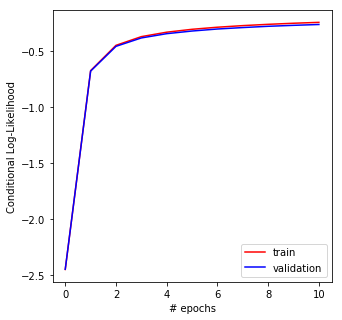

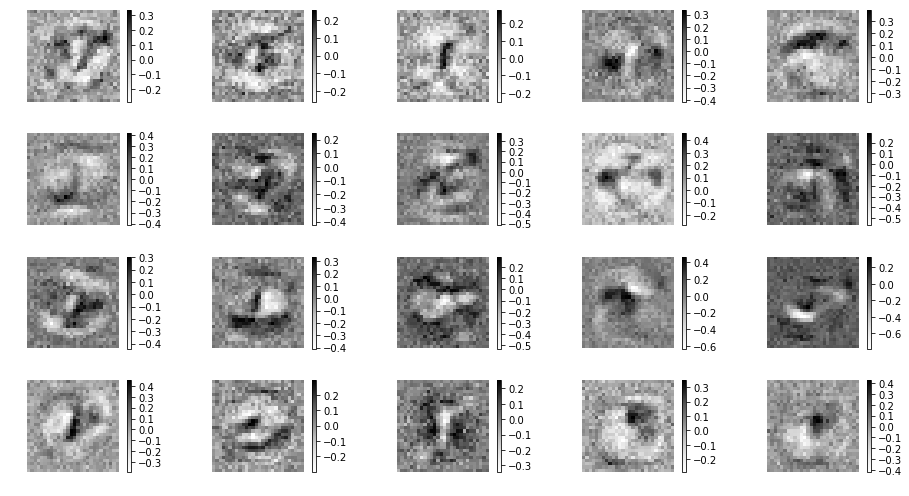

In [20]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

from IPython.display import ProgressBar

# Hyperparamters
n_epochs = 10
n_units = 20
lr = 1e-3

# Xavier initialization (PyTorch version)
V = np.random.normal(size=(28*28, n_units), scale=np.sqrt(2 / (28*28 + n_units)))
W = np.random.normal(size=(n_units, 10), scale=np.sqrt(2 / (n_units + 10)))
a = np.zeros((n_units, 1))
b = np.zeros((10, 1))

train_lll = [mlp_lll(x_train, t_train, V, a, W, b).mean()]
valid_lll = [mlp_lll(x_valid, t_valid, V, a, W, b).mean()]

# Train
for _ in ProgressBar(n_epochs):
    V, a, W, b = mlp_train_epoch(x_train, t_train, V, a, W, b, lr)
    train_lll.append(mlp_lll(x_train, t_train, V, a, W, b).mean())
    valid_lll.append(mlp_lll(x_valid, t_valid, V, a, W, b).mean())
    
# Plot Conditional Log-Likelihood
plt.figure(figsize=(5,5))
plt.plot(train_lll, 'r')
plt.plot(valid_lll, 'b')
plt.xlabel('# epochs')
plt.ylabel('Conditional Log-Likelihood')
plt.legend(['train', 'validation'])

# Plot weights
print('Weights of the first layer')
plt.figure(figsize=(13, 7))
plot_digits(V.T, num_cols=5)

Traning model with lr = 0.0001 ...


[============================================================] 10/10

Train Dataset conditional log-likelihood: -0.6794965807560387
Train Dataset accuracy: 0.86562
Validation Dataset conditional log-likelihood: -0.6861549338237153
Validation Dataset accuracy: 0.8615

Traning model with lr = 0.001 ...


[============================================================] 10/10

Train Dataset conditional log-likelihood: -0.24839240429752263
Train Dataset accuracy: 0.92964
Validation Dataset conditional log-likelihood: -0.2669360046046829
Validation Dataset accuracy: 0.9241

Traning model with lr = 0.01 ...


[============================================================] 10/10

Train Dataset conditional log-likelihood: -0.11819051506355487
Train Dataset accuracy: 0.96526
Validation Dataset conditional log-likelihood: -0.16210998812545427
Validation Dataset accuracy: 0.9498



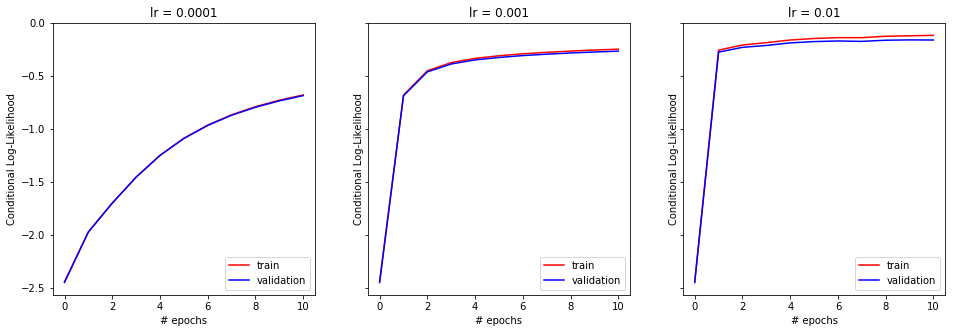

In [21]:
# plot the train and validation logp for all three learning rates in one figure
np.random.seed(123)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

# Xavier initialization (PyTorch version)
V_0 = np.random.normal(size=(28*28, n_units), scale=np.sqrt(2 / (28*28 + n_units)))
W_0 = np.random.normal(size=(n_units, 10), scale=np.sqrt(2 / (n_units + 10)))
a_0 = np.zeros((n_units, 1))
b_0 = np.zeros((10, 1))

for i, lr in enumerate([1e-4, 1e-3, 1e-2]):
    print(f'Traning model with lr = {lr} ...')
    
    # Initialize all experiments with the same random weights for fair comparisons
    V, W, a, b = V_0.copy(), W_0.copy(), a_0.copy(), b_0.copy()
    
    train_lll = [mlp_lll(x_train, t_train, V, a, W, b).mean()]
    valid_lll = [mlp_lll(x_valid, t_valid, V, a, W, b).mean()]

    # Train
    for _ in ProgressBar(n_epochs):
        V, a, W, b = mlp_train_epoch(x_train, t_train, V, a, W, b, lr)

        train_lll.append(mlp_lll(x_train, t_train, V, a, W, b).mean())
        valid_lll.append(mlp_lll(x_valid, t_valid, V, a, W, b).mean())
        
    print(f'Train Dataset conditional log-likelihood: {train_lll[-1]}')
    print(f'Train Dataset accuracy: {mlp_acc(x_train, t_train, V, a, W, b)}')
    print(f'Validation Dataset conditional log-likelihood: {valid_lll[-1]}')
    print(f'Validation Dataset accuracy: {mlp_acc(x_valid, t_valid, V, a, W, b)}')
    print()

    # Plot Conditional Log-Likelihood
    ax[i].plot(train_lll, 'r', label='train')
    ax[i].plot(valid_lll, 'b', label='validation')
    ax[i].set_title(f'lr = {lr}')
    ax[i].set_xlabel('# epochs')
    ax[i].set_ylabel('Conditional Log-Likelihood')
    ax[i].legend(loc='lower right')

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

When we use a small learning rate, such as $10^{-4}$, although our training and validation sets have a similar log-likelihood, they converge slower to the solution and after 10 epochs they score the lowest amongst our trials. On the other end, for a learning rate of $10^{-2}$, although the gap between training and validation is wider, we see a faster convergence at a higher value. Finally, for the intermediate value of $10^{-3}$, we have a compromise between the two.

**Rewrite:**
We observe that the higher the learning rate the faster the minimization of the conditional log-likelihood. A high learning rate could result in divergence (which doesn't happen here), while a low learning rate could result in a suboptimal solution (which happens here). We also observe a higher gap between the train and validation curves, which shouldn't probably be attributed to the learning rate itself but the overfitting it happens as the conditional log-likelihood approaches 0 (which is its theoretical limit).

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Epoch 0


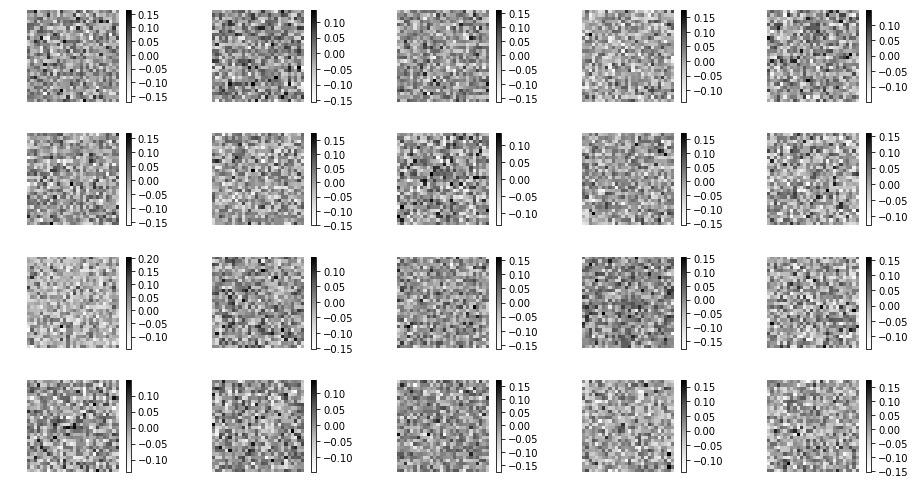

Epoch 4


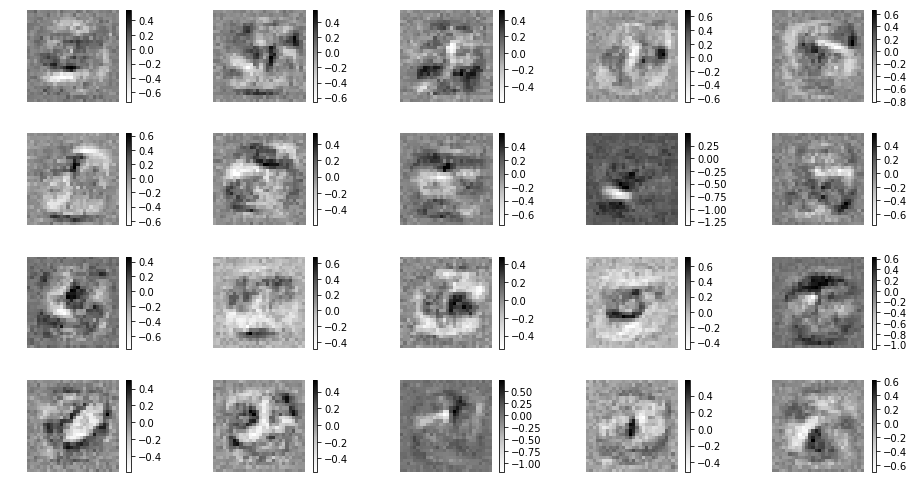

Epoch 9


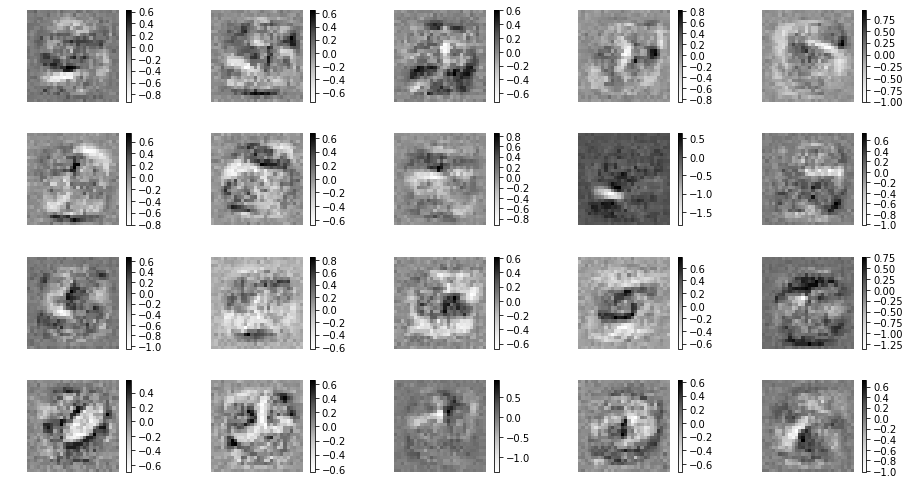

In [22]:
# Plot the weights of the first layer for the best model 

# Xavier initialization (PyTorch version)
V = np.random.normal(size=(28*28, n_units), scale=np.sqrt(2 / (28*28 + n_units)))
W = np.random.normal(size=(n_units, 10), scale=np.sqrt(2 / (n_units + 10)))
a = np.zeros((n_units, 1))
b = np.zeros((10, 1))

# Plot random weights (epoch 0)
print('Epoch 0')
plt.figure(figsize=(13, 7))
plot_digits(V.T, num_cols=5)

# Train
for epoch in range(n_epochs):
    V, a, W, b = mlp_train_epoch(x_train, t_train, V, a, W, b, lr=1e-2)

    # Plot weights every 5 epochs
    if epoch % 5 == 4:
        print(f'Epoch {epoch}')
        plt.figure(figsize=(13, 7))
        plot_digits(V.T, num_cols=5)

The weights $\mathbf{v}_i$ of the MLP do not correspond to the digits themselves, but rather more abstract features (like loops or straight lines) present in the digits. Then, in the final layer, $\mathbf{w_j}$ combines these features to form a classifier for each class. This gives more flexibility to the model to memorize a wider selection of patterns in the digits, and hence classify harder digits (like the ones of Section 1.2.3)

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

$$
\begin{aligned}
    \nabla_x \text{ReLU}(x) &=
    \begin{cases}
        0, & x < 0 \\
        1, & x > 0 \\
        \text{undefined}, & x = 0
    \end{cases} \\
    \nabla_x \tanh(x) &= 1 - \tanh^2(x)
\end{aligned}
$$

**Name two properties that you would like your activation function to have (one sentence each). Why are they important?**

We deem that an activation function should be:
- **continuously differentiable** w.r.t. the model's parameters, since we need its gradient to calculate the gradient of the error.
- **non-saturating**, i.e. it should be unbounded as $x$ approaches $\infty$ or $-\infty$, to prevent vanishing gradients which could stop training for parts of the network.

**Note:** we assume that any activation function is non-linear by definition, otherwise the MLP would degenerate to linear / logistic regression.

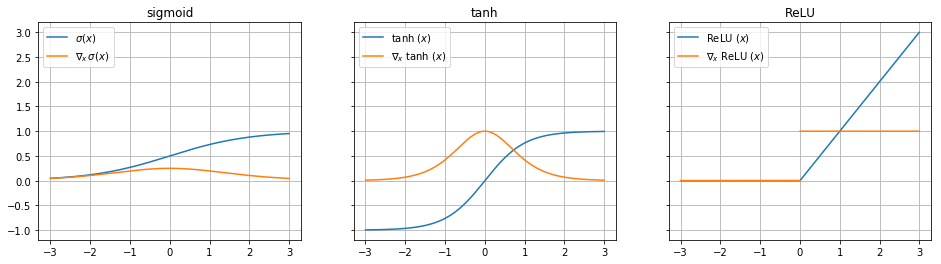

In [23]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.
x = np.linspace(-3, 3, 6001)

def tanh(x):
    return np.tanh(x)

def ReLU(x):
    return [p if p > 0 else 0 for p in x]

def step(x):
    #return [1 if p > 0 else 0 for p in x]
    return [1 if p > 0 else (0 if p < 0 else np.NaN) for p in x]

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))

ax[0].set_title('sigmoid')
ax[0].plot(x, sigmoid(x), label=r'$\sigma (x) $')
ax[0].plot(x, sigmoid(x) * (1 - sigmoid(x)), label=r'$\nabla_x \, \sigma (x) $')

ax[1].set_title('tanh')
ax[1].plot(x, tanh(x), label=r'tanh $(x)$')
ax[1].plot(x, 1 - tanh(x)**2, label=r'$\nabla_x$ tanh $(x)$')

ax[2].set_title('ReLU')
ax[2].plot(x, ReLU(x), label=r'ReLU $(x)$')
ax[2].plot(x, step(x), label=r'$\nabla_x$ ReLU $(x)$')

for axis in ax:
    axis.grid()
    axis.legend(loc='upper left')

**Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.**

The sigmoid and tanh exhibit are saturating functions, while the ReLU is not differentiable at $x=0$. Since we have an MLP with only 1 hidden layer, vanishing gradients are not of concern and hence the best activation function would be the sigmoid (since its gradient vanishes smoother that tanh's).

In [24]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 4.96 minutes.
